In [4]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import date,datetime,timedelta

# import tensorflow as tf
# from tensorflow.python.framework import ops
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [5]:
# Read XAUUSD Daily Price
xauusd = pl.read_csv("../data/xauusd_daily.csv",has_header=False)
# Defining columns with OHLCV
xauusd.columns = ['date','open','high','low','close','volume']
# Converting date column to datetime
xauusd = xauusd.with_columns(pl.col(['date']).str.strptime(pl.Date,'%Y.%m.%d %H:%M').cast(pl.Date))
xauusd.head(10)

shape: (10, 6)
┌────────────┬────────┬─────────┬────────┬────────┬────────┐
│ date       ┆ open   ┆ high    ┆ low    ┆ close  ┆ volume │
│ ---        ┆ ---    ┆ ---     ┆ ---    ┆ ---    ┆ ---    │
│ date       ┆ f64    ┆ f64     ┆ f64    ┆ f64    ┆ i64    │
╞════════════╪════════╪═════════╪════════╪════════╪════════╡
│ 2008-03-18 ┆ 1002.0 ┆ 1012.15 ┆ 976.35 ┆ 981.6  ┆ 30018  │
│ 2008-03-19 ┆ 981.6  ┆ 997.25  ┆ 937.55 ┆ 944.6  ┆ 35881  │
│ 2008-03-20 ┆ 944.6  ┆ 945.3   ┆ 904.33 ┆ 909.5  ┆ 34517  │
│ 2008-03-21 ┆ 909.9  ┆ 917.55  ┆ 906.85 ┆ 910.75 ┆ 274    │
│ …          ┆ …      ┆ …       ┆ …      ┆ …      ┆ …      │
│ 2008-03-26 ┆ 938.35 ┆ 954.45  ┆ 927.8  ┆ 953.7  ┆ 22644  │
│ 2008-03-27 ┆ 953.8  ┆ 954.65  ┆ 940.15 ┆ 947.15 ┆ 23157  │
│ 2008-03-28 ┆ 947.1  ┆ 950.75  ┆ 922.9  ┆ 930.1  ┆ 21939  │
│ 2008-03-31 ┆ 930.8  ┆ 940.65  ┆ 912.25 ┆ 915.65 ┆ 23779  │
└────────────┴────────┴─────────┴────────┴────────┴────────┘

In [6]:
# Read VIX Daily Price
vix = pl.read_csv("../data/vix_daily.csv")
vix.columns = ['date','open','high','low','close']
# Converting date column to datetime
vix = vix.with_columns(pl.col(['date']).str.strptime(pl.Date,'%m/%d/%Y').cast(pl.Date))
# Filter only the dates that is in XAUUSD daily price
vix = vix.filter(pl.col('date').is_in(xauusd['date']))
vix = vix.with_columns(pl.lit("VIX").alias("symbol"))
vix

shape: (4_005, 6)
┌────────────┬───────┬───────┬───────┬───────┬────────┐
│ date       ┆ open  ┆ high  ┆ low   ┆ close ┆ symbol │
│ ---        ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---    │
│ date       ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ str    │
╞════════════╪═══════╪═══════╪═══════╪═══════╪════════╡
│ 2008-03-18 ┆ 32.24 ┆ 32.24 ┆ 25.58 ┆ 25.79 ┆ VIX    │
│ 2008-03-19 ┆ 25.78 ┆ 29.95 ┆ 25.16 ┆ 29.84 ┆ VIX    │
│ 2008-03-20 ┆ 29.84 ┆ 29.84 ┆ 25.8  ┆ 26.62 ┆ VIX    │
│ 2008-03-24 ┆ 26.64 ┆ 27.04 ┆ 24.75 ┆ 25.73 ┆ VIX    │
│ …          ┆ …     ┆ …     ┆ …     ┆ …     ┆ …      │
│ 2024-01-22 ┆ 13.77 ┆ 13.84 ┆ 13.17 ┆ 13.19 ┆ VIX    │
│ 2024-01-23 ┆ 13.2  ┆ 13.29 ┆ 12.53 ┆ 12.55 ┆ VIX    │
│ 2024-01-24 ┆ 12.66 ┆ 13.18 ┆ 12.41 ┆ 13.14 ┆ VIX    │
│ 2024-01-25 ┆ 13.18 ┆ 13.58 ┆ 13.06 ┆ 13.45 ┆ VIX    │
└────────────┴───────┴───────┴───────┴───────┴────────┘

In [7]:
# Filter XAUUSD df with dates in VIX dates
xauusd = xauusd.filter(pl.col('date').is_in(vix['date']))
# Create a column with symbol name
xauusd = xauusd.with_columns(pl.lit("XAUUSD").alias("symbol"))
# Remove volume column since VIX doesn't have it
xauusd = xauusd.drop("volume")
# Concatenate both dataframes
df = pl.concat([xauusd,vix])
df

shape: (8_010, 6)
┌────────────┬────────┬─────────┬────────┬────────┬────────┐
│ date       ┆ open   ┆ high    ┆ low    ┆ close  ┆ symbol │
│ ---        ┆ ---    ┆ ---     ┆ ---    ┆ ---    ┆ ---    │
│ date       ┆ f64    ┆ f64     ┆ f64    ┆ f64    ┆ str    │
╞════════════╪════════╪═════════╪════════╪════════╪════════╡
│ 2008-03-18 ┆ 1002.0 ┆ 1012.15 ┆ 976.35 ┆ 981.6  ┆ XAUUSD │
│ 2008-03-19 ┆ 981.6  ┆ 997.25  ┆ 937.55 ┆ 944.6  ┆ XAUUSD │
│ 2008-03-20 ┆ 944.6  ┆ 945.3   ┆ 904.33 ┆ 909.5  ┆ XAUUSD │
│ 2008-03-24 ┆ 914.85 ┆ 927.1   ┆ 906.1  ┆ 915.05 ┆ XAUUSD │
│ …          ┆ …      ┆ …       ┆ …      ┆ …      ┆ …      │
│ 2024-01-22 ┆ 13.77  ┆ 13.84   ┆ 13.17  ┆ 13.19  ┆ VIX    │
│ 2024-01-23 ┆ 13.2   ┆ 13.29   ┆ 12.53  ┆ 12.55  ┆ VIX    │
│ 2024-01-24 ┆ 12.66  ┆ 13.18   ┆ 12.41  ┆ 13.14  ┆ VIX    │
│ 2024-01-25 ┆ 13.18  ┆ 13.58   ┆ 13.06  ┆ 13.45  ┆ VIX    │
└────────────┴────────┴─────────┴────────┴────────┴────────┘

By checking the content of data, we can see the weekends xauusd price are missing. 

In [8]:
# Summary Stats
xauusd.describe()

shape: (9, 7)
┌────────────┬────────────┬─────────────┬─────────────┬─────────────┬─────────────┬────────┐
│ describe   ┆ date       ┆ open        ┆ high        ┆ low         ┆ close       ┆ symbol │
│ ---        ┆ ---        ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---    │
│ str        ┆ str        ┆ f64         ┆ f64         ┆ f64         ┆ f64         ┆ str    │
╞════════════╪════════════╪═════════════╪═════════════╪═════════════╪═════════════╪════════╡
│ count      ┆ 4005       ┆ 4005.0      ┆ 4005.0      ┆ 4005.0      ┆ 4005.0      ┆ 4005   │
│ null_count ┆ 0          ┆ 0.0         ┆ 0.0         ┆ 0.0         ┆ 0.0         ┆ 0      │
│ mean       ┆ null       ┆ 1424.523728 ┆ 1435.174305 ┆ 1413.887571 ┆ 1424.743423 ┆ null   │
│ std        ┆ null       ┆ 316.529229  ┆ 317.781453  ┆ 314.850518  ┆ 316.333893  ┆ null   │
│ min        ┆ 2008-03-18 ┆ 679.55      ┆ 735.05      ┆ 679.55      ┆ 711.3       ┆ XAUUSD │
│ 25%        ┆ null       ┆ 1214.66     ┆ 1223.89     ┆ 1206.68     ┆ 1215.01     ┆ null   │
│ 50%        ┆ null       ┆ 1328.92     ┆ 1339.01     ┆ 1321.06     ┆ 1328.92     ┆ null   │
│ 75%        ┆ null       ┆ 1718.36     ┆ 1730.46     ┆ 1705.35     ┆ 1718.22     ┆ null   │
│ max        ┆ 2024-01-25 ┆ 2077.6      ┆ 2134.76     ┆ 2064.68     ┆ 2077.65     ┆ XAUUSD │
└────────────┴────────────┴─────────────┴─────────────┴─────────────┴─────────────┴────────┘

In [9]:
# Let's see how the gold price has changed over the last 15 years
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.filter(pl.col("symbol")=='XAUUSD')['date'], y=df.filter(pl.col("symbol")=='XAUUSD')['close'],mode='lines',name='XAUUSD'),secondary_y=False)
fig.add_trace(go.Scatter(x=df.filter(pl.col("symbol")=='VIX')['date'], y=df.filter(pl.col("symbol")=='VIX')['close'],mode='lines',name='VIX'),secondary_y=True)
fig.show()

In [10]:
# Calculate the Moving Average (MA) for gold price over the last 15 years
ma_days = [10, 30, 60, 90, 180]
for ma in ma_days:
    column_name = f"ma_{ma}_days"
    xauusd = xauusd.with_columns(pl.col("close").rolling_mean(ma).alias(column_name))
    vix = vix.with_columns(pl.col("close").rolling_mean(ma).alias(column_name))

# Plot the Moving Average (MA) for gold price over the last 15 years
fig = make_subplots(rows=2,cols=1,specs=[[{"secondary_y": True}],[{"secondary_y": True}]],subplot_titles=['Gold Price MA','VIX MA'])
fig.add_trace(go.Scatter(x=xauusd.to_pandas()['date'], y=xauusd.to_pandas()['close'], mode='lines', name='price'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Scatter(x=vix.to_pandas()['date'], y=vix.to_pandas()['close'], mode='lines', name='price'),row=2,col=1,secondary_y=False)
for ma in ma_days:
    column_name = f"ma_{ma}_days"
    fig.add_trace(go.Scatter(x=xauusd.to_pandas()['date'], y=xauusd.to_pandas()[column_name], mode='lines', name=f'{ma} Days MA'),row=1,col=1,secondary_y=False)
    fig.add_trace(go.Scatter(x=vix.to_pandas()['date'], y=vix.to_pandas()[column_name], mode='lines', name=f'{ma} Days MA'),row=2,col=1,secondary_y=False)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Price", row=2, col=1)
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_layout(title='Moving Averages',width=1800,height=1000)
fig.show()

In [11]:
# Daily Return of Gold on average
xauusd = xauusd.with_columns(pl.col("close").pct_change().alias("daily_return"))
vix = vix.with_columns(pl.col("close").pct_change().alias("daily_return"))

fig = make_subplots(rows=2,cols=1,subplot_titles=['Gold Daily Return','VIX Daily Return'])
fig.add_trace(go.Scatter(x=xauusd.to_pandas()['date'], y=xauusd.to_pandas()['daily_return'], mode='markers', name='daily_return'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Scatter(x=vix.to_pandas()['date'], y=vix.to_pandas()['daily_return'], mode='markers', name='daily_return'),row=2,col=1,secondary_y=False)
fig.update_layout(title='Daily Return',width=1500,height=1000)
fig.show()

In [12]:
# Average Daily Return on Histogram
fig = make_subplots(rows=2,cols=1,subplot_titles=['Gold Daily Return','VIX Daily Return'])
fig.add_trace(go.Histogram(x=xauusd.to_pandas()['daily_return'], name='daily_return'),row=1,col=1,secondary_y=False)
fig.add_trace(go.Histogram(x=vix.to_pandas()['daily_return'], name='daily_return'),row=2,col=1,secondary_y=False)
fig.update_layout(title='Average Daily Return')
fig.show()

# Correlation between XAUUSD and VIX

In [13]:
# Concat close price of both symbols
close = xauusd.select(['date','close']).join(vix.select(['date','close']), on='date', how='inner')
close.columns = ['date','xauusd','vix']
# Daily Return of Both Symbols
ret = close.with_columns(pl.col("xauusd").pct_change().alias("xauusd"),pl.col("vix").pct_change().alias("vix"))
ret.head(10)

shape: (10, 3)
┌────────────┬───────────┬───────────┐
│ date       ┆ xauusd    ┆ vix       │
│ ---        ┆ ---       ┆ ---       │
│ date       ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╡
│ 2008-03-18 ┆ null      ┆ null      │
│ 2008-03-19 ┆ -0.037694 ┆ 0.157038  │
│ 2008-03-20 ┆ -0.037159 ┆ -0.107909 │
│ 2008-03-24 ┆ 0.006102  ┆ -0.033434 │
│ …          ┆ …         ┆ …         │
│ 2008-03-27 ┆ -0.006868 ┆ -0.007669 │
│ 2008-03-28 ┆ -0.018001 ┆ -0.006569 │
│ 2008-03-31 ┆ -0.015536 ┆ -0.00389  │
│ 2008-04-01 ┆ -0.036695 ┆ -0.114408 │
└────────────┴───────────┴───────────┘

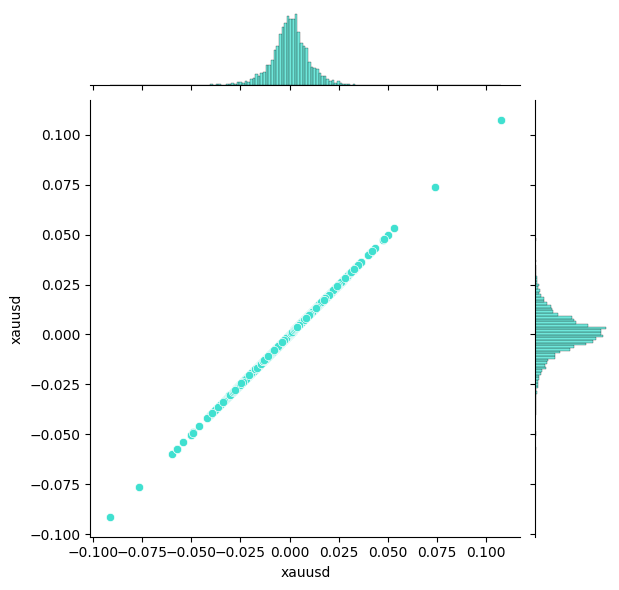

In [14]:
# Compare Daily Percentage Return of Two Symbols
# Comparing XAUUSD to itself should show a perfectly linear relationship
sns.jointplot(x='xauusd', y='xauusd', data=ret.to_pandas(), kind='scatter', color='turquoise')

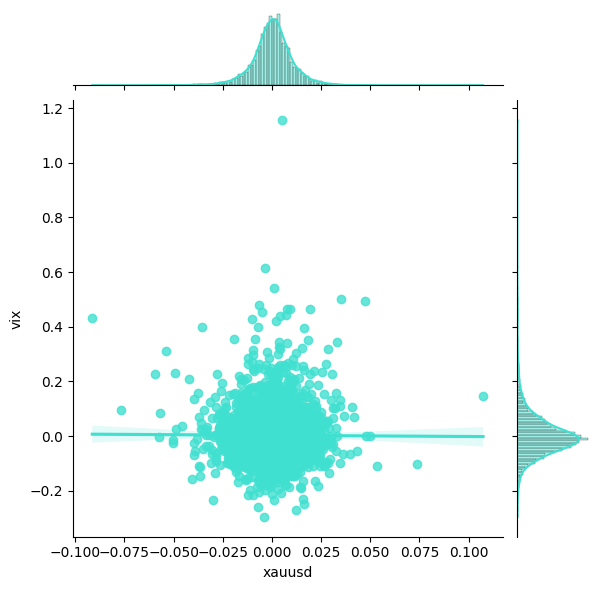

In [15]:
# Compare XAUUSD Return to VIX Return
sns.jointplot(x='xauusd', y='vix', data=ret.to_pandas(), kind='reg', color='turquoise')

We can see now that XAUUSD and VIX have no correlation

/var/folders/qn/9wj0qvwn7v7fb2zqtk66nywr0000gn/T/ipykernel_61736/829899418.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

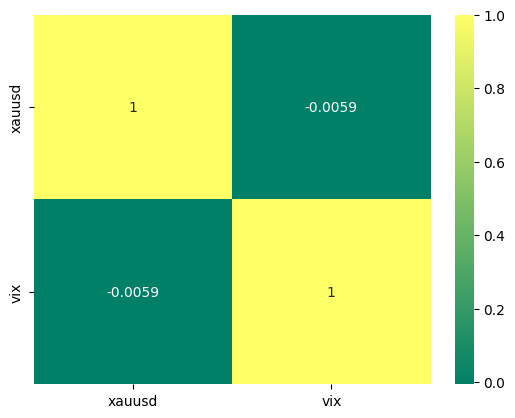

In [16]:
sns.heatmap(ret.to_pandas().corr(), annot=True, cmap='summer')

# Predict XAUUSD Price using LSTM

In [32]:
xau = xauusd.select(['date','close']).to_pandas()
xau.head(5)

date   close
0 2008-03-18  981.60
1 2008-03-19  944.60
2 2008-03-20  909.50
3 2008-03-24  915.05
4 2008-03-25  938.35

In [38]:
# Create a new dataframe with only the close price
dataset = xau['close'].values
print(f"number of days in the dataset: {len(dataset)}")
dataset

number of days in the dataset: 4005


array([ 981.6 ,  944.6 ,  909.5 , ..., 2029.25, 2013.62, 2020.81])

In [35]:
# Data Preprocessing
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95 ))
training_data_len

3805

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))
scaled_data

array([[0.19782633],
       [0.17074688],
       [0.145058  ],
       ...,
       [0.96457716],
       [0.95313792],
       [0.95840012]])

In [41]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.19782633, 0.17074688, 0.145058  , 0.14911992, 0.16617265,
       0.17740696, 0.17261317, 0.16013467, 0.14955904, 0.12496798,
       0.14099608, 0.13997146, 0.14787573, 0.15234018, 0.14857101,
       0.16273283, 0.15885388, 0.1563655 , 0.15563362, 0.15823179,
       0.17049072, 0.16613606, 0.15120577, 0.15010795, 0.14941267,
       0.14084971, 0.12763933, 0.12650492, 0.13287225, 0.11614886,
       0.12138178, 0.10297508, 0.10645149, 0.1188934 , 0.12043034,
       0.11483149, 0.12445567, 0.12730999, 0.12504117, 0.11362389,
       0.11168441, 0.12463864, 0.14022761, 0.14165477, 0.15193764,
       0.16174479, 0.15365755, 0.15621912, 0.14231346, 0.13839792,
       0.12149157, 0.12826143, 0.1314085 , 0.12335785, 0.12262597,
       0.12116222, 0.13887364, 0.13246972, 0.11340433, 0.12332126])]
[0.11457532842975815]

[array([0.19782633, 0.17074688, 0.145058  , 0.14911992, 0.16617265,
       0.17740696, 0.17261317, 0.16013467, 0.14955904, 0.12496798,
       0.14099608, 0.13997146, 0.14

In [42]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3745/3745 [==============================] - 95s 25ms/step - loss: 9.3124e-04


In [46]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset.reshape(-1,1)[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

7/7 [==============================] - 0s 18ms/step


25.558221209099994

/var/folders/qn/9wj0qvwn7v7fb2zqtk66nywr0000gn/T/ipykernel_61736/3930205438.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



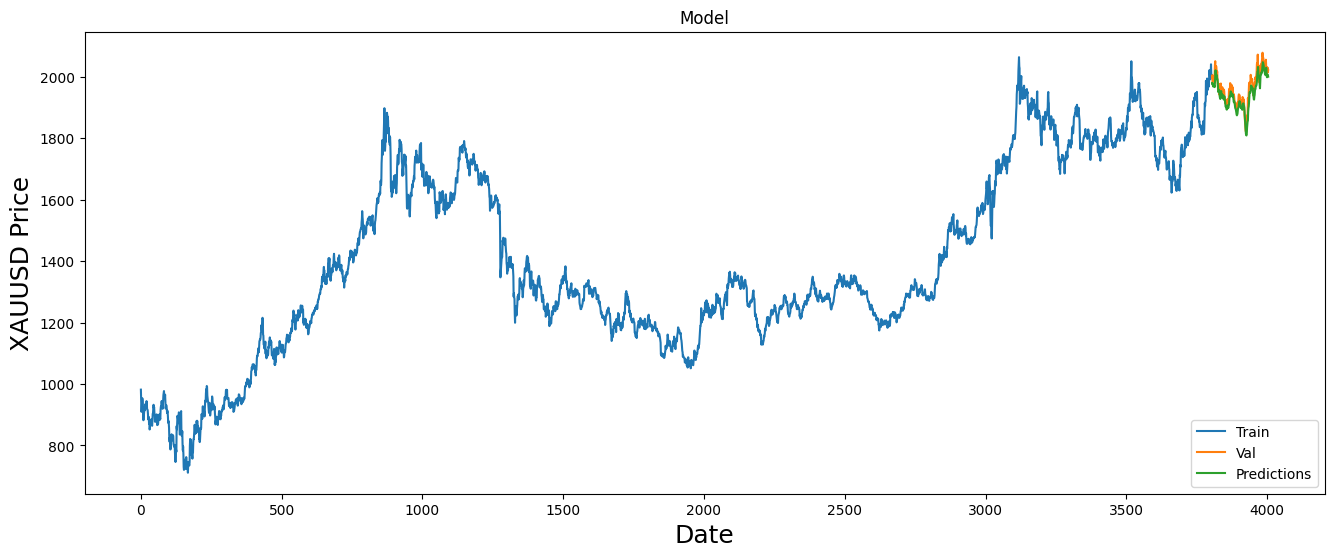

In [49]:
# Plot the data
data = xau[['close']]
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('XAUUSD Price', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [50]:
valid

close  Predictions
3805  1994.62  1979.066162
3806  2004.69  1974.686157
3807  1982.65  1977.988159
3808  1989.00  1969.657959
3809  1997.07  1967.590942
...       ...          ...
4000  2029.36  1997.773438
4001  2021.72  2002.655640
4002  2029.25  2002.561646
4003  2013.62  2005.943237
4004  2020.81  1999.827393

[200 rows x 2 columns]